# CHF Prediction with XGBoost using Short-Term HRV Signals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, fbeta_score, classification_report, \
                            roc_auc_score, \
                            ConfusionMatrixDisplay, RocCurveDisplay

import datetime
import os
import pprint

In [2]:
def classification_report_heatmap(cr, label_names, model_name):
    corr_matrix = []

    for label in label_names:
        if cr[label]:
            row = [cr[label]['precision'], cr[label]['recall'], cr[label]['f1-score']]
            corr_matrix.append(row)

    sns.heatmap(
        pd.DataFrame(np.array(corr_matrix), index=label_names, columns=['precision', 'recall', 'f1-score']),
        annot=True,
        cmap='Blues',
        vmin=0,
        vmax=1
    )

    plt.title("Classification Report Heatmap\nModel: {0}".format(model_name))
    plt.tight_layout()
    plt.show()

## Load Dataset

In [3]:
import pathlib

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
pathlib.Path(par_dir).parent.absolute()

WindowsPath('c:/Users/BIOINFO 9/Documents/Rino/HRV')

In [4]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# PROJECT_DIR = pathlib.Path(par_dir).parent.absolute()
# PROJECT_DIR = "/content/drive/MyDrive/Projects/HRV"
DATA_DIR = os.path.join(PROJECT_DIR, "dataset/short-term")

In [5]:
MINS_DIR = "5-min-2-hours-0.5-overlap-normal-beat-with-ectopic-info"
df_nsrdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsrdb.xlsx"))
df_chfdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chfdb.xlsx"))
df_nsr2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsr2db.xlsx"))
df_chf2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chf2db.xlsx"))
df = pd.concat(
    [
        df_nsr2db,
        df_chf2db,
    ],
    axis=0
).reset_index(drop=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3888 entries, 0 to 3887
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3888 non-null   object 
 1   start_secs              3888 non-null   int64  
 2   end_secs                3888 non-null   int64  
 3   db_source               3888 non-null   object 
 4   age                     3888 non-null   float64
 5   gender                  3888 non-null   object 
 6   fs                      3888 non-null   int64  
 7   signal_length           0 non-null      float64
 8   recording_time_hours    0 non-null      float64
 9   recording_time_seconds  0 non-null      float64
 10  normal_beats            3888 non-null   int64  
 11  abnormal_beats          3888 non-null   int64  
 12  normal_beats_ratio      3888 non-null   float64
 13  rri_length              3888 non-null   int64  
 14  nni_length              3888 non-null   

## Data Cleaning & Filtering

In [7]:
df_loaded = df.copy()

In [8]:
map_gender = {"m": 1, "f": 0}

# df = df.dropna()
df = df_loaded.copy()
df = df[(df.age != "?") & (df.gender != "?")]
df = df.replace(["?"], np.nan)
df['age'] = np.array(df['age'], dtype=np.float16)
df['gender'] = df['gender'].map(lambda x: map_gender[x.lower()])
df["record_ids"] = df["id"].map(lambda x: "-".join(x.split("-")[:2]))
df = df[["id", "record_ids"] + df.drop(columns=["id", "record_ids"]).columns.to_list()]
df = df.drop(columns=['tinn'])
df = df.replace([np.inf, -np.inf], np.nan)
# df = df[df['age'] >= 10] # useless since no data with age > 10 in CHFDB, CHF2DB, NSRDB, NSR2DB
df = df[df["normal_beats_ratio"] >= 0.9]

if 'db_source' in df.columns:
    db_source = df['db_source']
    df = df.drop(columns=['db_source'])
drop_columns = ["signal_length", "recording_time_hours", "recording_time_seconds"]
df = df.drop(columns=drop_columns)

df = df.dropna()
df["ratio_sd1_sd2"] = 1 / df["ratio_sd2_sd1"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2945 entries, 0 to 3030
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2945 non-null   object 
 1   record_ids          2945 non-null   object 
 2   start_secs          2945 non-null   int64  
 3   end_secs            2945 non-null   int64  
 4   age                 2945 non-null   float16
 5   gender              2945 non-null   int64  
 6   fs                  2945 non-null   int64  
 7   normal_beats        2945 non-null   int64  
 8   abnormal_beats      2945 non-null   int64  
 9   normal_beats_ratio  2945 non-null   float64
 10  rri_length          2945 non-null   int64  
 11  nni_length          2945 non-null   int64  
 12  mean_nni            2945 non-null   float64
 13  sdnn                2945 non-null   float64
 14  sdsd                2945 non-null   float64
 15  nni_50              2945 non-null   int64  
 16  pnni_5

In [9]:
db_source.value_counts()

nsr2db    2517
chf2db     428
Name: db_source, dtype: int64

## Train-Test Split

In [10]:
train_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "train_record_ids_7-3_post-filter.csv"))
test_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "test_record_ids_7-3_post-filter.csv"))

df_train = df[
    df["record_ids"].isin(train_record_ids["id"].values)
]

df_test = df[
    df["record_ids"].isin(test_record_ids["id"].values)
]

print(df_train.shape)
print(df_test.shape)

df_train.sample(3)

(2269, 46)
(676, 46)


,id,record_ids,start_secs,end_secs,age,gender,fs,normal_beats,abnormal_beats,normal_beats_ratio,...,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk,ratio_sd1_sd2
2643,chf2db-chf202-6300-6600,chf2db-chf202,6300,6600,59.0,0,128,457,3,0.993478,...,17.024657,39.955070,2.346894,2.346894,4.036770,375.081298,1.780141,NYHA class: III,1,0.426095
2418,nsr2db-nsr052-1350-1650,nsr2db-nsr052,1350,1650,39.0,1,128,626,0,1.000000,...,8.186025,21.322022,2.604686,2.604686,3.446021,222.148676,1.389580,Sinus,0,0.383923
1832,nsr2db-nsr039-6000-6300,nsr2db-nsr039,6000,6300,70.0,0,128,380,4,0.989583,...,41.548554,78.670396,1.893457,1.893457,4.718487,595.836017,0.536780,Sinus,0,0.528135


In [11]:
df_inspect = df_test.copy()

In [12]:
data_info = ['age', 'gender', 'db_source']
time_domain_indices = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
freq_domain_indices = ['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']
geometrical_indices = ['triangular_index']
poincare_plot_indices = ['sd1', 'sd2', 'ratio_sd1_sd2']
csi_csv_indices = ['csi', 'cvi', 'Modified_csi']
sampen = ['sampen']
disease_info = ['cardiac_info', 'risk']

## Feature Selection

In [13]:
columns_needed = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices + \
                 ['risk']

df_train = df_train[columns_needed]
df_test = df_test[columns_needed]

X_train = df_train.drop(columns=['risk'])
y_train = df_train['risk']
X_test = df_test.drop(columns=['risk'])
y_test = df_test['risk']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2269, 31) (2269,)
(676, 31) (676,)


In [14]:
print(y_train.value_counts())
print(y_test.value_counts())

0    1910
1     359
Name: risk, dtype: int64
0    607
1     69
Name: risk, dtype: int64


In [15]:
pd.set_option('display.max_columns', None)
df_train.sample(3)

,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi,risk
731,73.0,0,752.611020,104.999556,46.516241,14,3.693931,79,20.844327,46.521521,792.96875,550.78125,0.061813,0.139514,81.884579,185.060241,68.571429,16.160138,550.845783,493.605711,1.115963,52.740198,47.259802,1454.246605,409.795111,32.935429,144.793201,0.227465,4.396275,4.882531,2546.202904,0
118,67.0,0,821.106628,28.806521,18.382971,3,0.826446,111,30.578512,18.383777,820.31250,148.43750,0.022389,0.035083,73.161928,80.000000,66.782609,2.565935,295.473659,39.235436,7.530786,88.277750,11.722250,509.891374,175.182279,13.016665,38.603080,0.337192,2.965666,3.905242,457.935347,0
2141,63.0,0,634.852707,43.753234,14.868170,1,0.212766,86,18.297872,14.869099,617.18750,210.93750,0.023421,0.068919,94.933174,108.169014,78.367347,6.159450,175.853037,23.969681,7.336478,88.004527,11.995473,445.609935,245.787217,10.524586,60.974782,0.172606,5.793556,4.011475,1413.043296,0


In [16]:
pd.reset_option('display.max_columns')

In [17]:
LABEL_NAMES = ["Healthy", "CHF"]

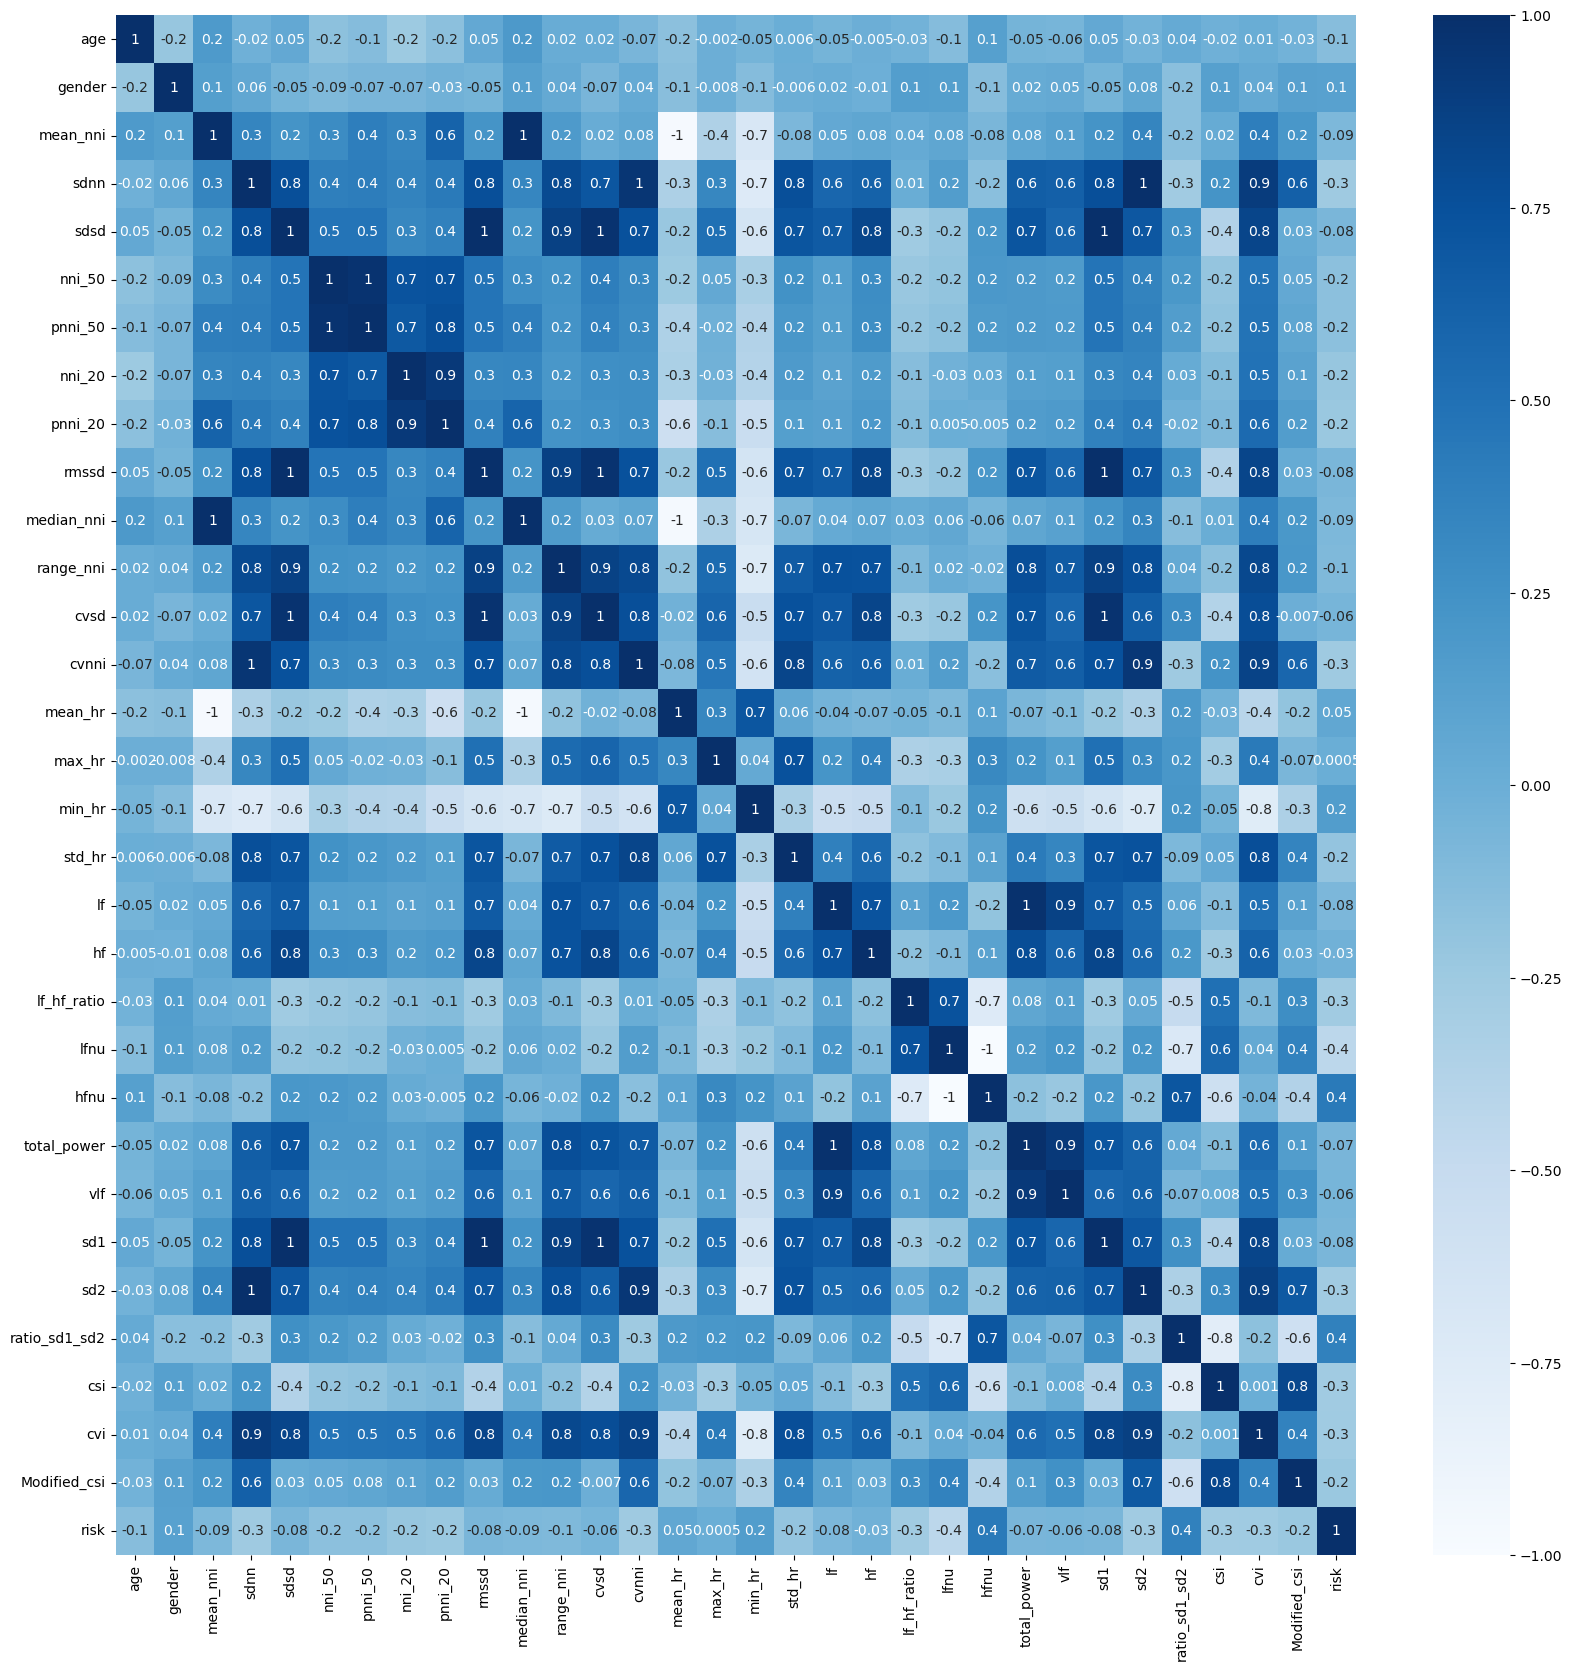

In [18]:
plt.rcParams['figure.figsize'] = (20, 20)
heatmap = sns.heatmap(df_train.corr(), annot=True, cmap="Blues", fmt='.1g')
plt.rcdefaults()
plt.show()

## XGBoost

In [19]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut

from sklearn.metrics import make_scorer

In [20]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

In [21]:
# A parameter grid for XGBoost
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [22]:
gs = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [23]:
start = datetime.datetime.now()
gs.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 31)
Fitting time: 0 hours, 6 minutes, 36 seconds, 151182 microseconds


## Evaluation

In [24]:
gs.score(X_test, y_test)

0.9334319526627219

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




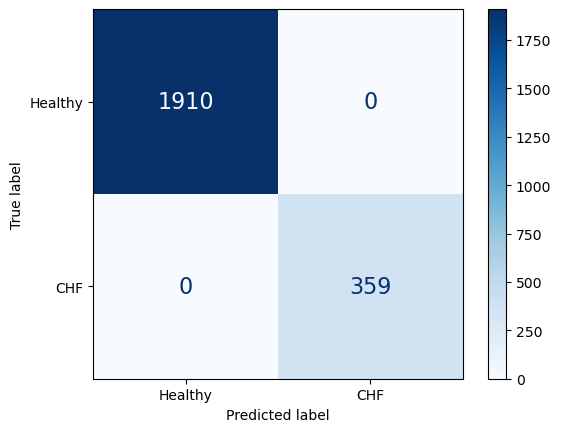


TEST SET RESULTS
TN, FP, FN, TP       : 580 27 18 51
Accuracy             : 0.9334319526627219
Precision            : 0.9376397656883894
Sensitivity          : 0.7391304347826086
Specificity          : 0.9555189456342669
F1-Score             : 0.9352211556625402
AUC Score            : 0.8473246902084377
              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.96       607
         CHF       0.65      0.74      0.69        69

    accuracy                           0.93       676
   macro avg       0.81      0.85      0.83       676
weighted avg       0.94      0.93      0.94       676




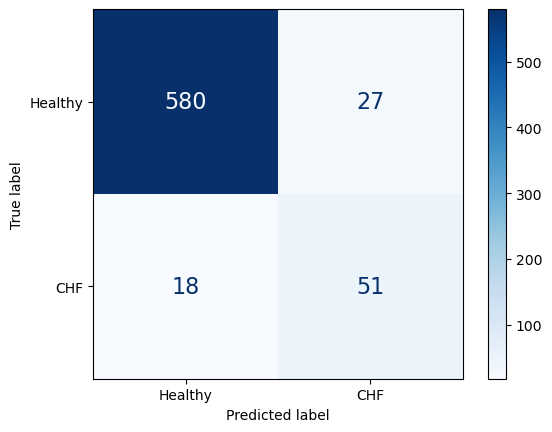

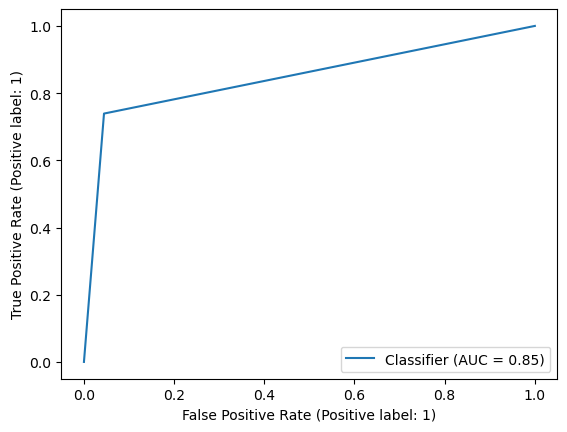

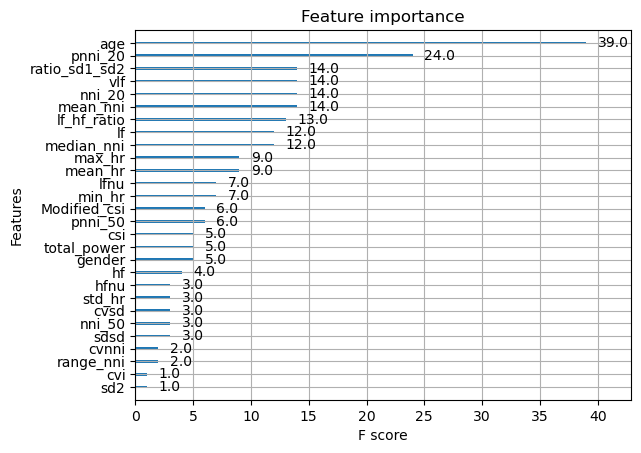

In [25]:
y_pred_train = gs.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs.best_estimator_)
plt.show()

In [26]:
print("Best Params")
pprint.pprint(gs.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 1.0}



### Sensitivity

In [27]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall",
)

In [28]:
start = datetime.datetime.now()
gs_sensitivity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 31)
Fitting time: 0 hours, 6 minutes, 38 seconds, 776551 microseconds


In [29]:
gs_sensitivity.score(X_test, y_test)

0.8695652173913043

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




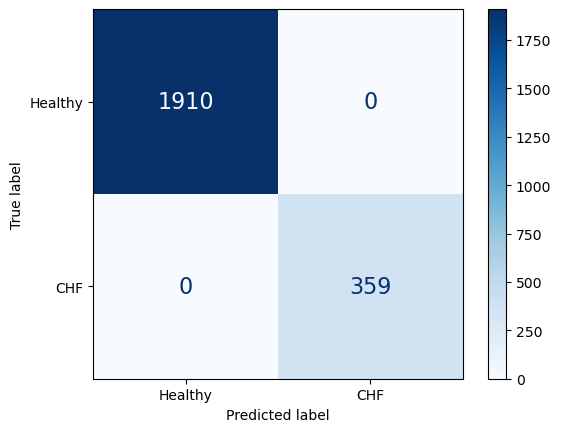


TEST SET RESULTS
TN, FP, FN, TP       : 570 37 9 60
Accuracy             : 0.9319526627218935
Precision            : 0.9471082532699885
Sensitivity          : 0.8695652173913043
Specificity          : 0.9390444810543658
F1-Score             : 0.9368883378490366
AUC Score            : 0.9043048492228349
              precision    recall  f1-score   support

     Healthy       0.98      0.94      0.96       607
         CHF       0.62      0.87      0.72        69

    accuracy                           0.93       676
   macro avg       0.80      0.90      0.84       676
weighted avg       0.95      0.93      0.94       676




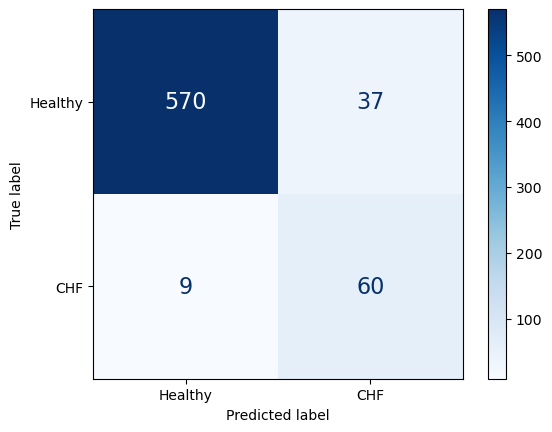

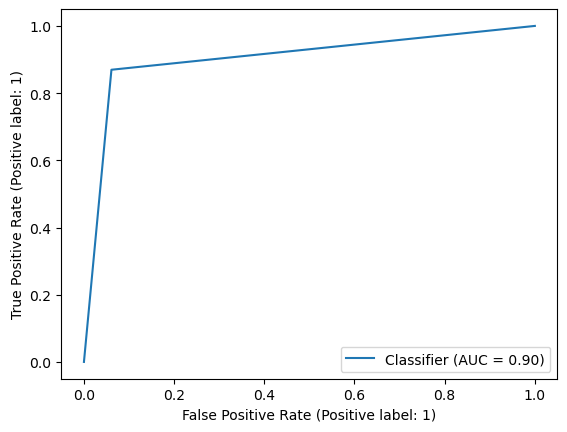

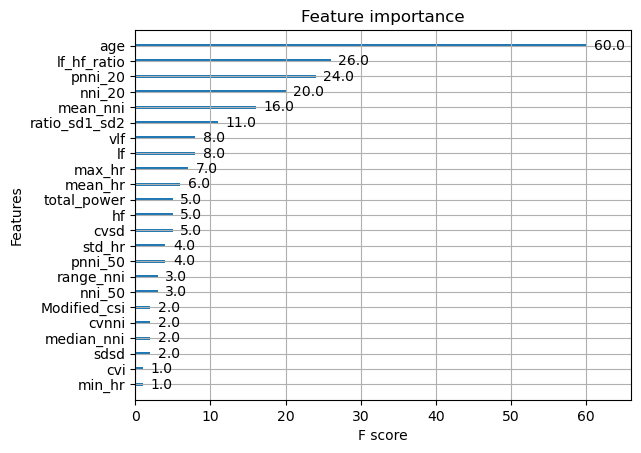

In [30]:
y_pred_train = gs_sensitivity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_sensitivity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity.best_estimator_)
plt.show()

In [31]:
print("Best Params")
pprint.pprint(gs_sensitivity.best_params_)
print()

Best Params
{'colsample_bytree': 1.0,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 1.0}



### Specificity

In [32]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

specificity = make_scorer(recall_score, pos_label=0)

gs_specificity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring=specificity,
)

In [33]:
start = datetime.datetime.now()
gs_specificity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 31)
Fitting time: 0 hours, 6 minutes, 41 seconds, 937201 microseconds


In [34]:
gs_specificity.score(X_test, y_test)

0.9456342668863262

TRAIN SET RESULTS
TN, FP, FN, TP       : 1906 4 10 349
Accuracy (Train)     : 0.9938298810048479
Precision (Train)    : 0.993813718189303
Sensitivity (Train)  : 0.9721448467966574
Specificity (Train)  : 0.9979057591623036
F1-Score (Train)     : 0.9938087213566202
AUC Score (Train)    : 0.9850253029794805
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00      1910
         CHF       0.99      0.97      0.98       359

    accuracy                           0.99      2269
   macro avg       0.99      0.99      0.99      2269
weighted avg       0.99      0.99      0.99      2269




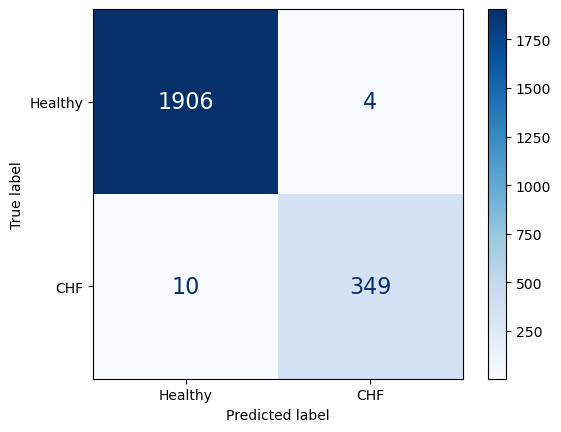


TEST SET RESULTS
TN, FP, FN, TP       : 574 33 14 55
Accuracy             : 0.9304733727810651
Precision            : 0.940344111017188
Sensitivity          : 0.7971014492753623
Specificity          : 0.9456342668863262
F1-Score             : 0.9341276758538789
AUC Score            : 0.8713678580808443
              precision    recall  f1-score   support

     Healthy       0.98      0.95      0.96       607
         CHF       0.62      0.80      0.70        69

    accuracy                           0.93       676
   macro avg       0.80      0.87      0.83       676
weighted avg       0.94      0.93      0.93       676




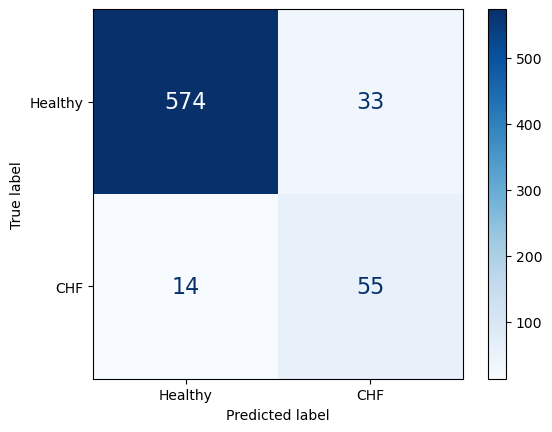

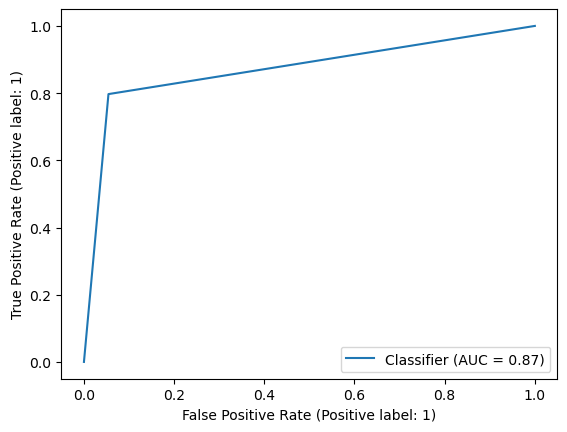

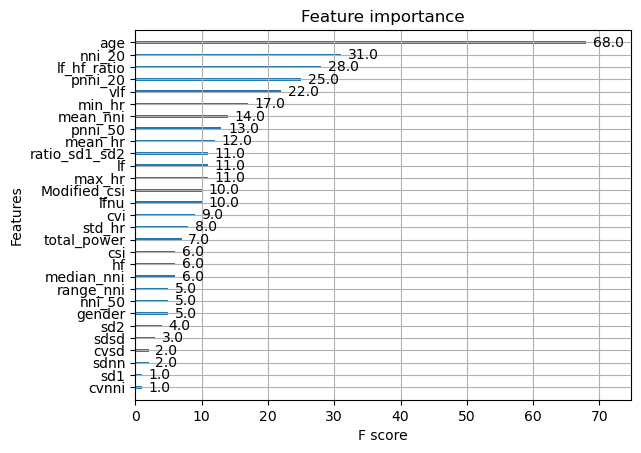

In [35]:
y_pred_train = gs_specificity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_specificity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_specificity.best_estimator_)
plt.show()

In [36]:
print("Best Params")
pprint.pprint(gs_specificity.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 150,
 'subsample': 0.6}



## Save model

In [37]:
import pickle
# Ref: https://stackoverflow.com/questions/57730192/how-to-save-gridsearchcv-xgboost-model

# Dictionary of best parameters
best_pars = gs.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = gs.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))

In [38]:
# Ref: https://stackoverflow.com/a/64823806

import joblib

#save your model or results
gs_filename = f"xgb-gs-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs, os.path.join(MODEL_DIR, gs_filename))

#load your model for further usage
gs_best = joblib.load(os.path.join(MODEL_DIR, gs_filename))


In [39]:
gs_best.best_estimator_.score(X_test, y_test), gs_best.best_params_

(0.9334319526627219,
 {'colsample_bytree': 0.6,
  'gamma': 1,
  'learning_rate': 0.4,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 50,
  'subsample': 1.0})

### Sensitivity

In [40]:
import pickle

# Best XGB model that was found based on the metric score you specify
best_model = gs_sensitivity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-sensitivity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_sensitivity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_sensitivity_filename = f"xgb-gs_sensitivity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_sensitivity, os.path.join(MODEL_DIR, gs_sensitivity_filename))

#load your model for further usage
gs_sensitivity_best = joblib.load(os.path.join(MODEL_DIR, gs_sensitivity_filename))
print(gs_sensitivity_best.best_params_)

{'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.4, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}


### Specificity

In [41]:
import pickle
import joblib

# Best XGB model that was found based on the metric score you specify
best_model = gs_specificity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-specificity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_specificity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_specificity_filename = f"xgb-gs_specificity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_specificity, os.path.join(MODEL_DIR, gs_specificity_filename))

#load your model for further usage
gs_specificity_best = joblib.load(os.path.join(MODEL_DIR, gs_specificity_filename))
print(gs_specificity_best.best_params_)

{'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 150, 'subsample': 0.6}


## Feature Selection

In [42]:
# ref: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
importance_score = gs.best_estimator_.get_booster().get_score(importance_type='weight')
top_importance_score = {k: v for k, v in sorted(importance_score.items(), key=lambda item: item[1], reverse=True)}

top_5_features = []
top_10_features = []
top_15_features = []
for k, v in top_importance_score.items():
    if len(top_5_features) < 5:
        top_5_features.append(k)
    if len(top_10_features) < 10:
        top_10_features.append(k)
    if len(top_15_features) < 15:
        top_15_features.append(k)

### ReFit - Top 5

In [43]:
X_top_5_train = X_train[top_5_features]
X_top_5_test = X_test[top_5_features]

print(X_top_5_train.shape, y_train.shape)
print(X_top_5_test.shape, y_test.shape)

(2269, 5) (2269,)
(676, 5) (676,)


In [44]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_5 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [45]:
start = datetime.datetime.now()
gs_sensitivity_top_5.fit(X_top_5_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_5_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 5)
Fitting time: 0 hours, 2 minutes, 35 seconds, 295370 microseconds


In [46]:
gs_sensitivity_top_5.score(X_top_5_test, y_test)

0.8115942028985508

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 2 357
Accuracy (Train)     : 0.999118554429264
Precision (Train)    : 0.9991194764434593
Sensitivity (Train)  : 0.9944289693593314
Specificity (Train)  : 1.0
F1-Score (Train)     : 0.9991175539841994
AUC Score (Train)    : 0.9972144846796658
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      0.99      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




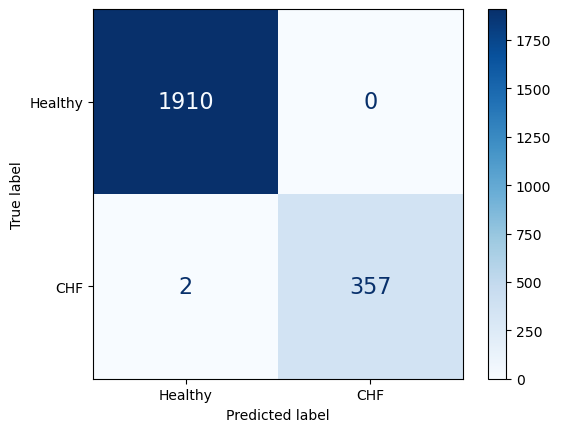


TEST SET RESULTS
TN, FP, FN, TP       : 557 50 13 56
Accuracy             : 0.9068047337278107
Precision            : 0.9313742167744918
Sensitivity          : 0.8115942028985508
Specificity          : 0.9176276771004942
F1-Score             : 0.9151919683479711
AUC Score            : 0.8646109399995224
              precision    recall  f1-score   support

     Healthy       0.98      0.92      0.95       607
         CHF       0.53      0.81      0.64        69

    accuracy                           0.91       676
   macro avg       0.75      0.86      0.79       676
weighted avg       0.93      0.91      0.92       676




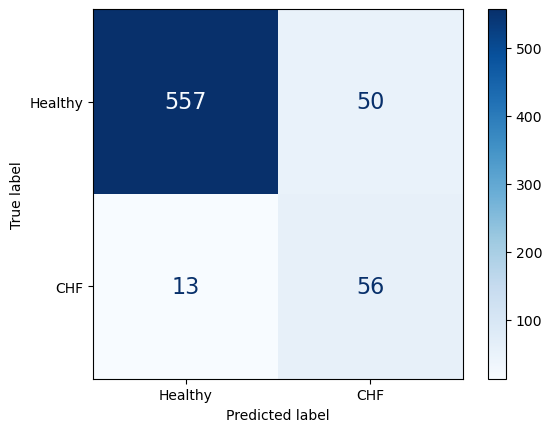

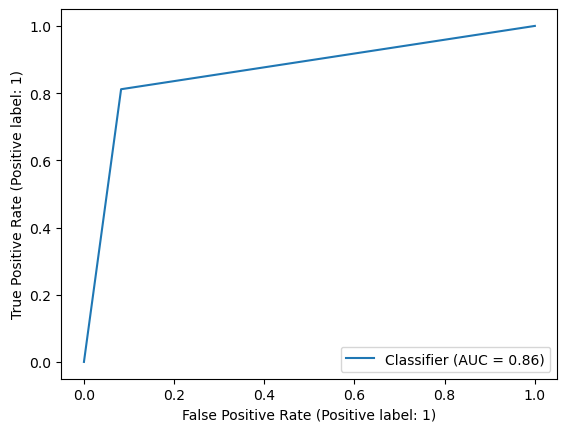

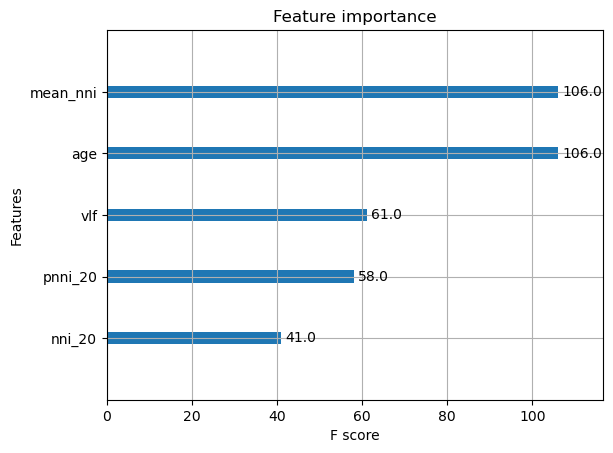

In [47]:
y_pred_train = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_5.best_estimator_)
plt.show()

### ReFit - Top 10

In [48]:
X_top_10_train = X_train[top_10_features]
X_top_10_test = X_test[top_10_features]

print(X_top_10_train.shape, y_train.shape)
print(X_top_10_test.shape, y_test.shape)

(2269, 10) (2269,)
(676, 10) (676,)


In [49]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_10 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [50]:
start = datetime.datetime.now()
gs_sensitivity_top_10.fit(X_top_10_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_10_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 10)
Fitting time: 0 hours, 3 minutes, 8 seconds, 930771 microseconds


In [51]:
gs_sensitivity_top_10.score(X_top_10_test, y_test)

0.9097633136094675

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 1 358
Accuracy (Train)     : 0.999559277214632
Precision (Train)    : 0.9995595078388002
Sensitivity (Train)  : 0.9972144846796658
Specificity (Train)  : 1.0
F1-Score (Train)     : 0.9995590275476982
AUC Score (Train)    : 0.9986072423398329
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




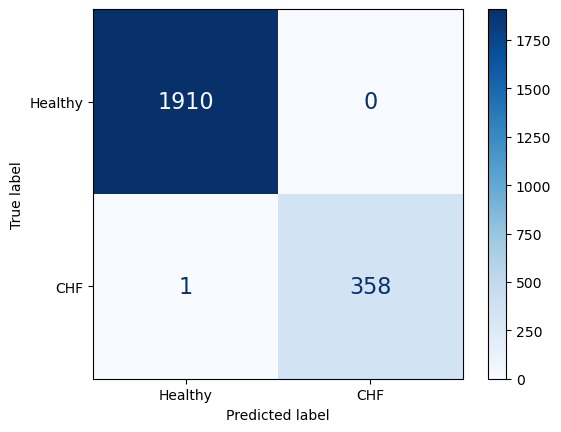


TEST SET RESULTS
TN, FP, FN, TP       : 561 46 15 54
Accuracy             : 0.9097633136094675
Precision            : 0.9296637697238659
Sensitivity          : 0.782608695652174
Specificity          : 0.9242174629324547
F1-Score             : 0.9168571528607942
AUC Score            : 0.8534130792923142
              precision    recall  f1-score   support

     Healthy       0.97      0.92      0.95       607
         CHF       0.54      0.78      0.64        69

    accuracy                           0.91       676
   macro avg       0.76      0.85      0.79       676
weighted avg       0.93      0.91      0.92       676




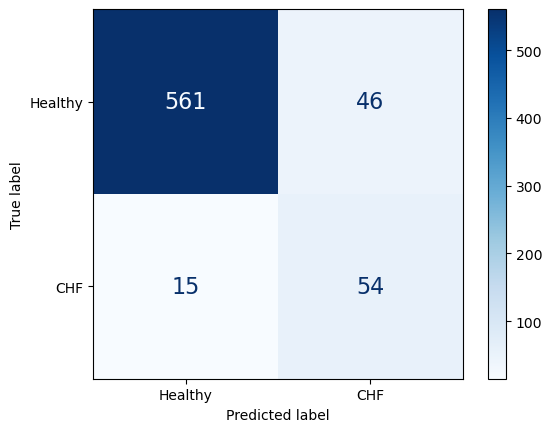

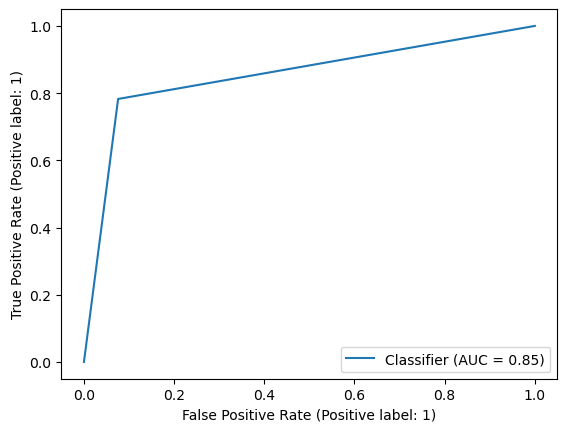

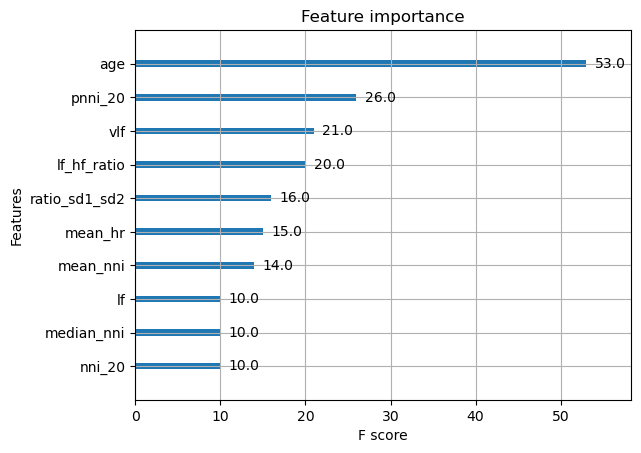

In [52]:
y_pred_train = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_10.best_estimator_)
plt.show()

### ReFit - Top 15

In [53]:
X_top_15_train = X_train[top_15_features]
X_top_15_test = X_test[top_15_features]

print(X_top_15_train.shape, y_train.shape)
print(X_top_15_test.shape, y_test.shape)

(2269, 15) (2269,)
(676, 15) (676,)


In [54]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_15 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [55]:
start = datetime.datetime.now()
gs_sensitivity_top_15.fit(X_top_15_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_15_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 15)
Fitting time: 0 hours, 3 minutes, 54 seconds, 894729 microseconds


In [56]:
gs_sensitivity_top_15.score(X_top_15_test, y_test)

0.9334319526627219

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




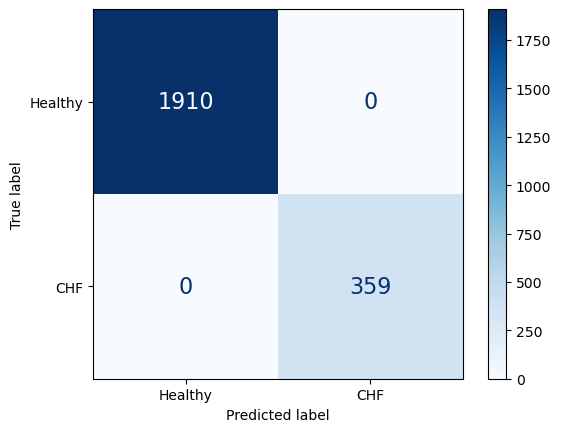


TEST SET RESULTS
TN, FP, FN, TP       : 571 36 9 60
Accuracy             : 0.9334319526627219
Precision            : 0.9477899918384003
Sensitivity          : 0.8695652173913043
Specificity          : 0.9406919275123559
F1-Score             : 0.9381213368965297
AUC Score            : 0.9051285724518301
              precision    recall  f1-score   support

     Healthy       0.98      0.94      0.96       607
         CHF       0.62      0.87      0.73        69

    accuracy                           0.93       676
   macro avg       0.80      0.91      0.84       676
weighted avg       0.95      0.93      0.94       676




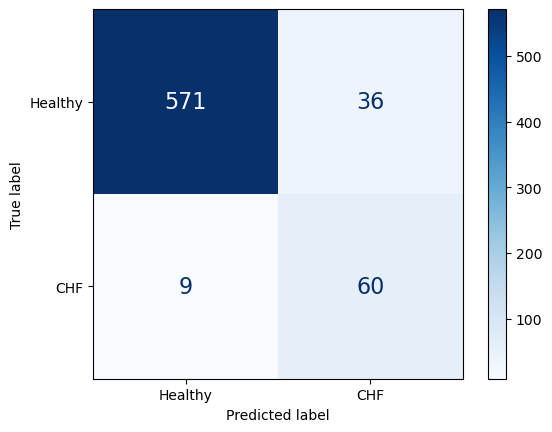

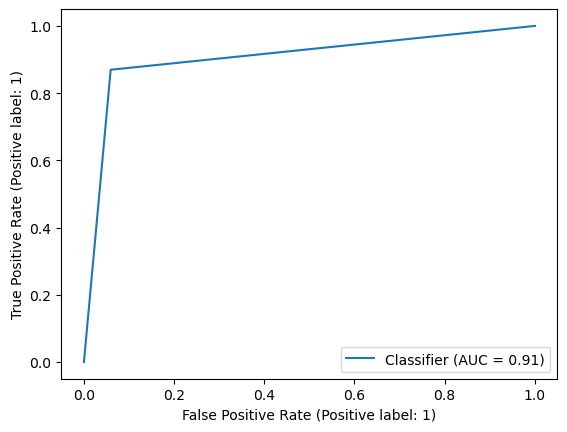

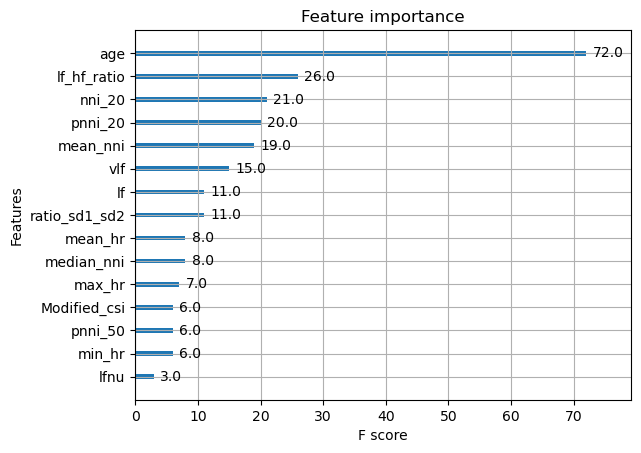

In [57]:
y_pred_train = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_15.best_estimator_)
plt.show()

## Feature Reduction

### Remove Age

In [58]:
columns_wo_age = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_age.remove("age")

In [59]:
X_wo_age_train = X_train[columns_wo_age]
X_wo_age_test = X_test[columns_wo_age]

print(X_wo_age_train.shape, y_train.shape)
print(X_wo_age_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_age_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 30) (2269,)
(676, 30) (676,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
1898,0,882.766544,162.781766,161.853086,19,11.242604,73,43.195266,161.853086,875.0000,1390.625000,0.183348,0.184400,69.852422,146.285714,33.318872,12.675923,18103.075116,6507.785478,2.781757,73.557262,26.442738,32884.551708,8273.691114,114.787527,199.548567,0.575236,1.738417,5.564063,1387.594333
1761,1,583.719758,137.568040,109.452522,6,1.293103,59,12.715517,109.452543,570.3125,1462.402344,0.187509,0.235675,105.182172,199.480519,34.029355,12.031466,23551.459338,2370.450973,9.935434,90.855416,9.144584,39595.050411,13673.140100,77.478155,178.457465,0.434155,2.303326,5.344834,1644.183020
583,0,606.132971,27.896602,12.937015,1,0.202840,58,11.764706,12.937636,601.5625,195.312500,0.021345,0.046024,99.188271,109.714286,80.842105,4.363118,178.814338,21.973208,8.137835,89.056489,10.943511,387.537549,186.750003,9.157143,38.374309,0.238627,4.190642,3.749921,643.252007


In [60]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_age = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)


In [61]:
start = datetime.datetime.now()
gs_sensitivity_wo_age.fit(X_wo_age_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_age_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 30)
Fitting time: 0 hours, 8 minutes, 39 seconds, 779576 microseconds


In [62]:
gs_sensitivity_wo_age.score(X_wo_age_test, y_test)

0.5942028985507246

TRAIN SET RESULTS
TN, FP, FN, TP       : 1907 3 10 349
Accuracy (Train)     : 0.9942706037902159
Precision (Train)    : 0.9942604038332828
Sensitivity (Train)  : 0.9721448467966574
Specificity (Train)  : 0.9984293193717277
F1-Score (Train)     : 0.9942476398563844
AUC Score (Train)    : 0.9852870830841925
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00      1910
         CHF       0.99      0.97      0.98       359

    accuracy                           0.99      2269
   macro avg       0.99      0.99      0.99      2269
weighted avg       0.99      0.99      0.99      2269




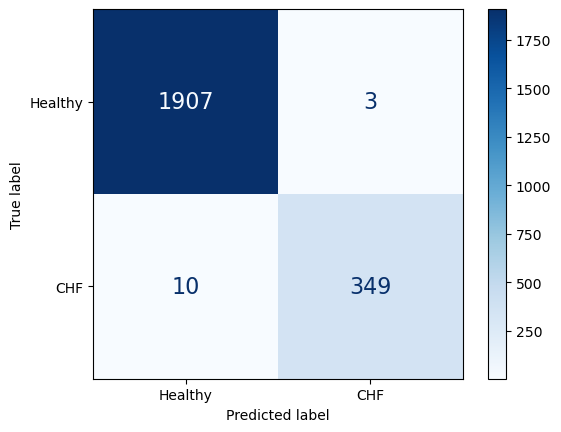


TEST SET RESULTS
TN, FP, FN, TP       : 582 25 28 41
Accuracy             : 0.9215976331360947
Precision            : 0.9201203273397472
Sensitivity          : 0.5942028985507246
Specificity          : 0.9588138385502472
F1-Score             : 0.9208231297037314
AUC Score            : 0.776508368550486
              precision    recall  f1-score   support

     Healthy       0.95      0.96      0.96       607
         CHF       0.62      0.59      0.61        69

    accuracy                           0.92       676
   macro avg       0.79      0.78      0.78       676
weighted avg       0.92      0.92      0.92       676




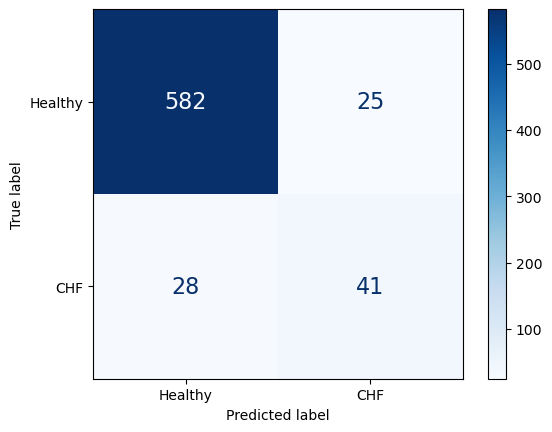

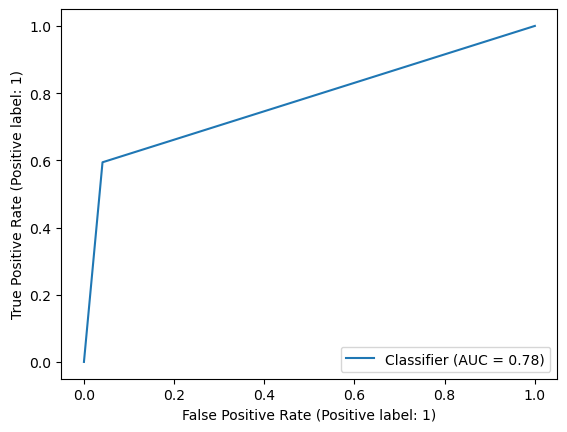

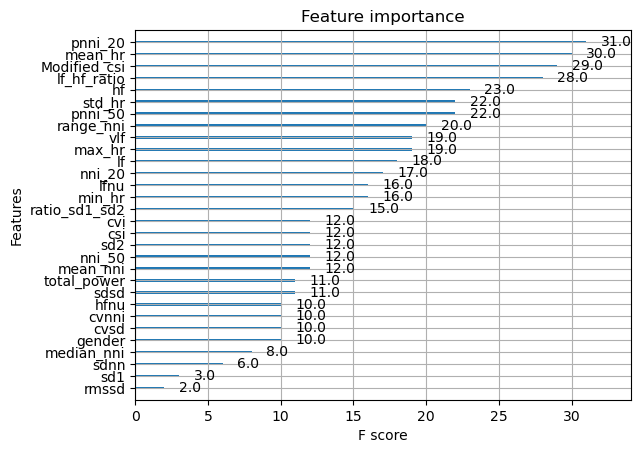

In [63]:
y_pred_train = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_age.best_estimator_)
plt.show()

### Remove LF/HF

In [64]:
columns_wo_lf_hf_ratio = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_lf_hf_ratio.remove("lf_hf_ratio")

In [65]:
X_wo_lf_hf_ratio_train = X_train[columns_wo_lf_hf_ratio]
X_wo_lf_hf_ratio_test = X_test[columns_wo_lf_hf_ratio]

print(X_wo_lf_hf_ratio_train.shape, y_train.shape)
print(X_wo_lf_hf_ratio_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_lf_hf_ratio_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 30) (2269,)
(676, 30) (676,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
1799,70.0,0,837.250712,79.890910,74.783457,30,8.571429,122,34.857143,74.784420,851.5625,609.37500,0.089321,0.095421,72.855896,160.000000,60.952381,12.821642,893.389913,1165.699411,43.387623,56.612377,2459.978372,400.889048,52.955595,99.803908,0.530596,1.884672,4.927179,752.390388
1391,70.0,0,597.461327,42.462124,25.125296,2,0.400000,81,16.200000,25.125418,601.5625,347.65625,0.042054,0.071071,100.981191,172.584270,86.292135,8.035739,121.748233,173.457041,41.241890,58.758110,367.470343,72.265069,17.784060,57.356701,0.310061,3.225175,4.212735,739.941524
317,76.0,1,687.338362,73.226616,74.932522,32,7.373272,131,30.184332,74.932522,695.3125,441.40625,0.109018,0.106536,89.094718,176.551724,76.800000,17.130109,827.949150,1219.173569,40.444529,59.555471,2292.518925,245.396206,53.046443,88.940146,0.596429,1.676647,4.877874,596.484823


In [66]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_lf_hf_ratio = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [67]:
start = datetime.datetime.now()
gs_sensitivity_wo_lf_hf_ratio.fit(X_wo_lf_hf_ratio_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_lf_hf_ratio_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 30)
Fitting time: 0 hours, 6 minutes, 35 seconds, 876208 microseconds


In [68]:
gs_sensitivity_wo_lf_hf_ratio.score(X_wo_lf_hf_ratio_test, y_test)

0.782608695652174

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




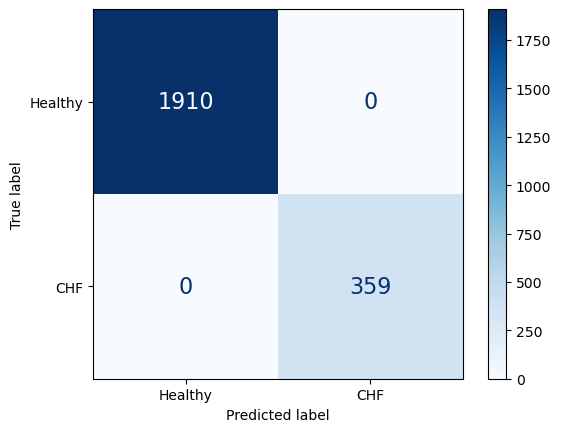


TEST SET RESULTS
TN, FP, FN, TP       : 574 33 15 54
Accuracy             : 0.9289940828402367
Precision            : 0.9384159498996947
Sensitivity          : 0.782608695652174
Specificity          : 0.9456342668863262
F1-Score             : 0.9325562525974156
AUC Score            : 0.86412148126925
              precision    recall  f1-score   support

     Healthy       0.97      0.95      0.96       607
         CHF       0.62      0.78      0.69        69

    accuracy                           0.93       676
   macro avg       0.80      0.86      0.83       676
weighted avg       0.94      0.93      0.93       676




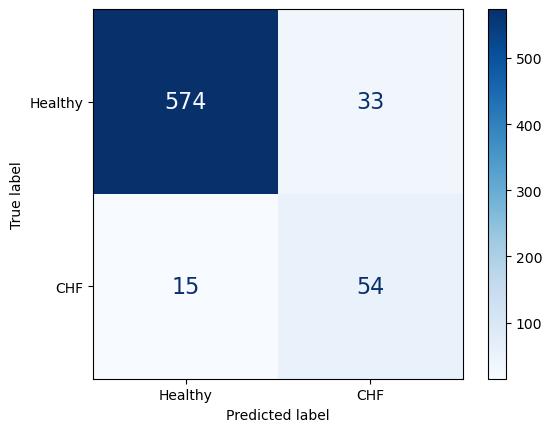

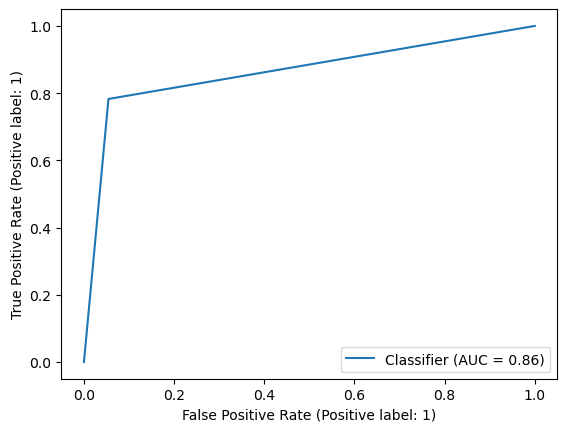

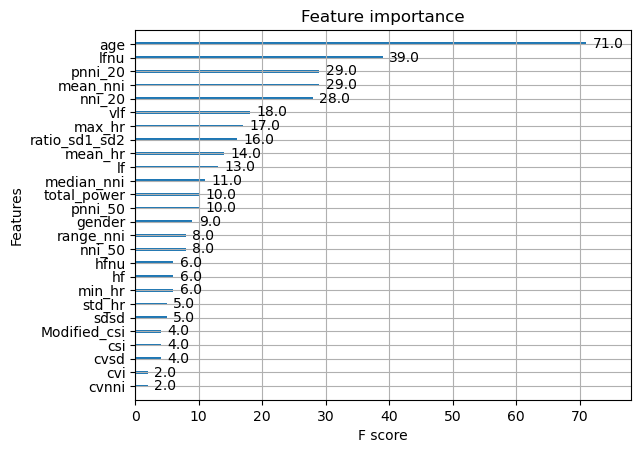

In [69]:
y_pred_train = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_lf_hf_ratio.best_estimator_)
plt.show()

### Remove NNI_20

In [70]:
columns_wo_nni_20 = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_nni_20.remove("nni_20")

In [71]:
X_wo_nni_20_train = X_train[columns_wo_nni_20]
X_wo_nni_20_test = X_test[columns_wo_nni_20]

print(X_wo_nni_20_train.shape, y_train.shape)
print(X_wo_nni_20_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_nni_20_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 30) (2269,)
(676, 30) (676,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
2163,63.0,0,746.571072,33.335566,16.128970,4,1.000000,15.500000,16.129549,742.1875,281.2500,0.021605,0.044652,80.523206,91.428571,64.000000,3.503615,298.082381,29.146110,10.227175,91.093040,8.906960,589.934860,262.706369,11.419187,45.739721,0.249656,4.005515,3.922049,732.844501
1521,65.0,1,959.134615,138.859495,40.598629,12,4.026846,35.570470,40.614277,1015.6250,718.7500,0.042345,0.144776,64.260674,150.588235,53.706294,12.324938,696.337802,331.811129,2.098597,67.727328,32.272672,2090.640692,1062.491762,28.755854,194.260184,0.148028,6.755500,4.951230,5249.298998
401,66.0,1,744.616760,67.352866,33.742461,28,6.982544,33.915212,33.744086,734.3750,429.6875,0.045317,0.090453,81.204306,111.304348,61.935484,6.976950,1076.541809,274.706234,3.918884,79.670185,20.329815,2237.608242,886.360199,23.889329,92.206926,0.259084,3.859754,4.547087,1423.584113


In [72]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_nni_20 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [73]:
start = datetime.datetime.now()
gs_sensitivity_wo_nni_20.fit(X_wo_nni_20_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_nni_20_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 30)
Fitting time: 0 hours, 6 minutes, 40 seconds, 744890 microseconds


In [74]:
gs_sensitivity_wo_nni_20.score(X_wo_nni_20_test, y_test)

0.8115942028985508

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




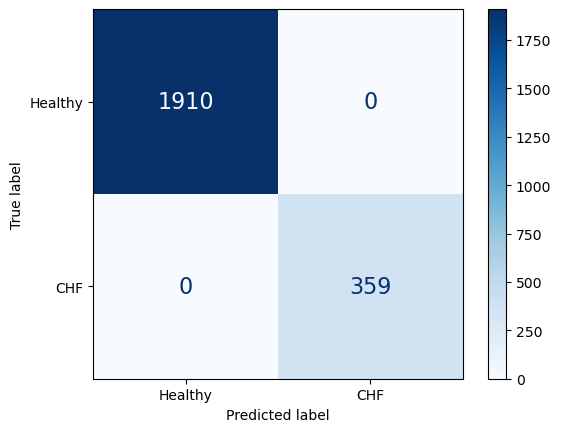


TEST SET RESULTS
TN, FP, FN, TP       : 580 27 13 56
Accuracy             : 0.9408284023668639
Precision            : 0.947111394779353
Sensitivity          : 0.8115942028985508
Specificity          : 0.9555189456342669
F1-Score             : 0.9432082424997404
AUC Score            : 0.8835565742664089
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       607
         CHF       0.67      0.81      0.74        69

    accuracy                           0.94       676
   macro avg       0.83      0.88      0.85       676
weighted avg       0.95      0.94      0.94       676




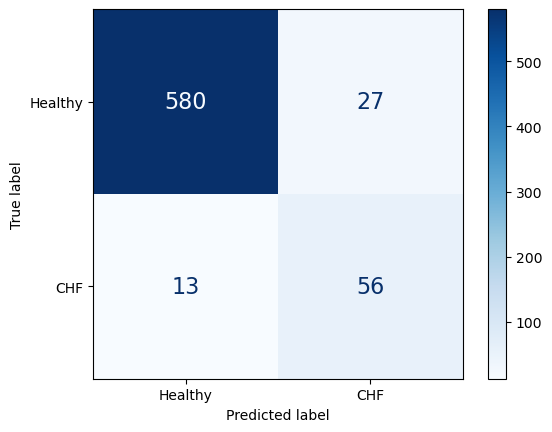

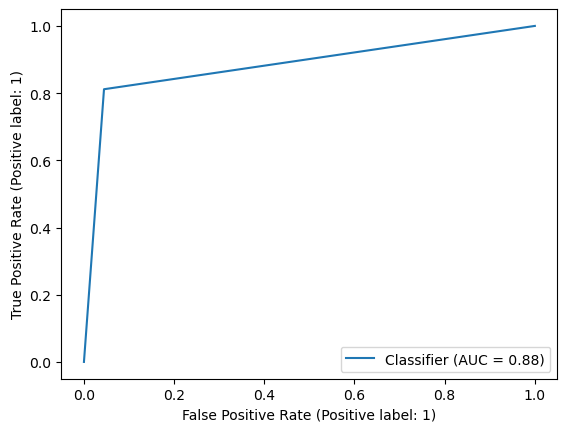

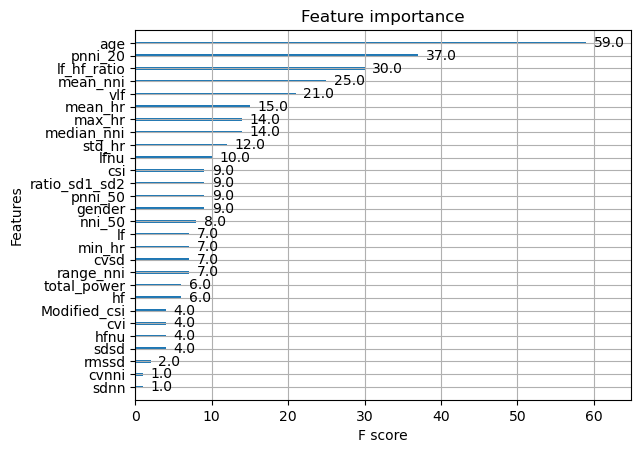

In [75]:
y_pred_train = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_nni_20.best_estimator_)
plt.show()

### Remove Age, LF/HF, NNI_20

In [76]:
columns_wo_all = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_all.remove("age")
columns_wo_all.remove("lf_hf_ratio")
columns_wo_all.remove("nni_20")

In [77]:
X_wo_all_train = X_train[columns_wo_all]
X_wo_all_test = X_test[columns_wo_all]

print(X_wo_all_train.shape, y_train.shape)
print(X_wo_all_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_all_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 28) (2269,)
(676, 28) (676,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
898,0,588.592829,30.030893,20.217308,18,3.543307,22.637795,20.217401,585.9375,140.625,0.034349,0.051022,102.200686,114.626866,90.352941,5.163261,166.243816,52.696449,75.931130,24.068870,460.999495,242.059230,14.309887,39.986701,0.357866,2.794341,3.961672,446.945885
1250,1,500.781250,28.877911,10.058536,0,0.000000,5.128205,10.063299,507.8125,156.250,0.020095,0.057666,120.208727,134.736842,99.740260,6.896716,48.624406,6.886476,87.594368,12.405632,154.899818,99.388936,7.120763,40.213955,0.177072,5.647422,3.661023,908.420735
728,0,801.538462,99.580060,54.562296,7,2.160494,24.074074,54.571694,828.1250,875.000,0.068084,0.124236,76.509061,192.000000,50.526316,14.290203,623.916527,411.856229,60.236816,39.763184,2108.578305,1072.805550,38.641047,135.422472,0.285337,3.504627,4.922860,1898.421235


In [78]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_all = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [79]:
start = datetime.datetime.now()
gs_sensitivity_wo_all.fit(X_wo_all_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_all_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 28)
Fitting time: 0 hours, 8 minutes, 17 seconds, 963562 microseconds


In [80]:
gs_sensitivity_wo_all.score(X_wo_all_test, y_test)

0.6376811594202898

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




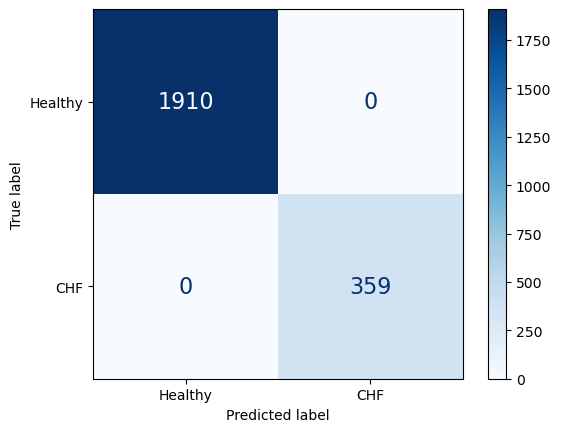


TEST SET RESULTS
TN, FP, FN, TP       : 575 32 25 44
Accuracy             : 0.915680473372781
Precision            : 0.9196090262638845
Sensitivity          : 0.6376811594202898
Specificity          : 0.9472817133443163
F1-Score             : 0.917471266621779
AUC Score            : 0.7924814363823031
              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.95       607
         CHF       0.58      0.64      0.61        69

    accuracy                           0.92       676
   macro avg       0.77      0.79      0.78       676
weighted avg       0.92      0.92      0.92       676




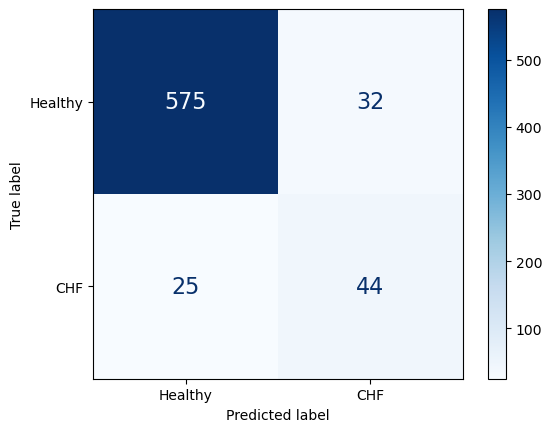

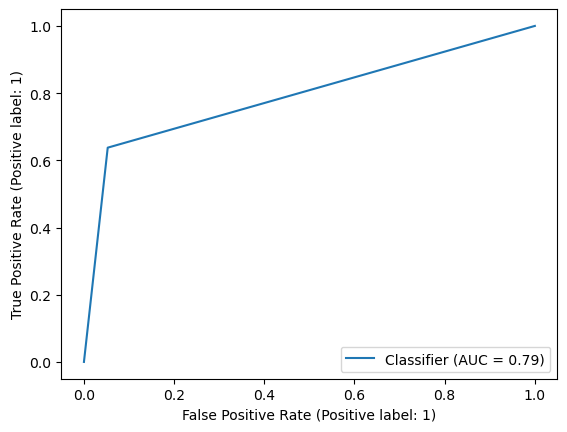

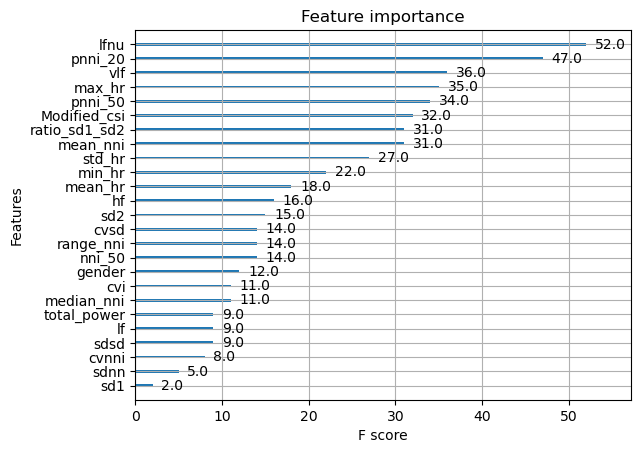

In [81]:
y_pred_train = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_all.best_estimator_)
plt.show()